In [12]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GlobalAvgPool1D
from keras.preprocessing.text import Tokenizer
# from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras import metrics

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [13]:
'''Step1 Data Processing'''
# Read the data.csv file into data frame
data_df = pd.read_csv("processed_data.csv", encoding='unicode_escape')
data1 = data_df.loc[:, "text"]        # content
data2 = data_df.loc[:, "generated"]   # labels
data_new = pd.concat([data1, data2], axis=1)
# print(data_new)

# Split the input data and label into train and test ones
def split_train_test(input_data, ratio_test):
    np.random.seed(314)
    # Randomly shuffle the order of the data points
    shuffled_indices = np.random.permutation(len(input_data))
    test_size = int(len(input_data) * ratio_test)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return input_data.iloc[train_indices], input_data.iloc[test_indices]

# Split the data and labels into training and testing
train_data, test_data = split_train_test(data1, 0.2)
train_label, test_label = split_train_test(data2, 0.2)

# The input data is the text in format of string
texts_train = train_data.astype(str)
texts_test = test_data.astype(str)

In [14]:
# change the text and label into the numerical format
tokenizer_train = Tokenizer()
tokenizer_train.fit_on_texts(texts_train)
sequences_train = tokenizer_train.texts_to_sequences(texts_train)
# print(sequences_train)
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(texts_test)
sequences_test = tokenizer_test.texts_to_sequences(texts_test)
# print(sequences_test)

# padding the sequence into the same length
data_train = pad_sequences(sequences_train)
# print(data_train)
data_test = pad_sequences(sequences_test)
# print(data_test)

In [15]:
'''Step2: Convolutional Neural Network (CNN)'''
# the size of vocabulary list
vocab_size = len(data_train)
# the dimension of words after embedding
embedding_dim = 128
# the maximum number of words of each input line
max_length = 100 # longer part will be thrown, shorter part will be assigned as 0

# initialize the model
# Model structure: 
model = Sequential([
    # Embedding layer, transform the sequence into vectors
    Embedding(vocab_size, embedding_dim
              ),
    # 1-Dimension Convolution layers
    # Conv1D(filters, kernel_size, padding='valid', activation=None)
    Conv1D(256, 5, padding='same'
           ),
    GlobalMaxPooling1D(),
    # Full-connected layer
    # Dense(units, activation=None)
    # Output layer
    Dense(1,
          activation='sigmoid'
          )
    ])

In [16]:
# compiling the model
model.compile(loss='binary_crossentropy',   # loss function
              optimizer='adam',             # optimizer
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])         # assessment criteria

# Train the CNN model
model.fit(data_train, train_label,
          epochs=2,                        # epoch is the training round
          validation_split=0.2  # The ratio of evaluate set in training set
          )
# Get the summary of the CNN model
model.summary()

# test and evaluate the model, accacz = model.evaluate(data_test, test_label)
predict_result = model.predict(data_test)   # The classifying result of test data
model.evaluate(data_test, test_label)

length = len(test_label)
# print(len(predict_result) == length)
score = 0
for i in range(length):
    current = 0
    if predict_result[i][0] > 0.5:
        current = 1
    if current == test_label.tolist()[i]:
        score += 1
print('Calculated accuracy: ', score/length)


Epoch 1/2
583/583 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - accuracy: 0.8724 - loss: 0.2426 - precision_2: 0.9186 - recall_2: 0.7209 - val_accuracy: 0.9869 - val_loss: 0.0389 - val_precision_2: 0.9844 - val_recall_2: 0.9828
Epoch 2/2
583/583 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.9946 - loss: 0.0173 - precision_2: 0.9956 - recall_2: 0.9908 - val_accuracy: 0.9893 - val_loss: 0.0340 - val_precision_2: 0.9913 - val_recall_2: 0.9817


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 880, 128)            │       2,983,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 880, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,442,949 (36.02 MB)

 Trainable params: 3,147,649 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,295,300 (24.01 MB)

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6727 - loss: 1.0548 - precision_2: 0.6127 - recall_2: 0.5223
Calculated accuracy:  0.6721592859594919


<function matplotlib.pyplot.show(close=None, block=None)>

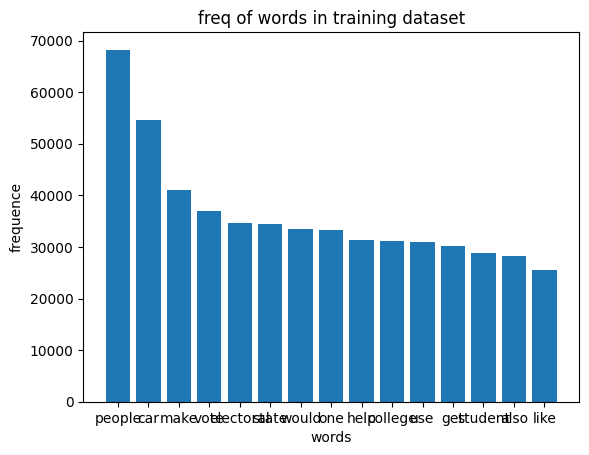

In [18]:
word_counts=tokenizer_train.word_counts
word_counts_Desc=sorted(word_counts.items(), key=lambda x:x[1],reverse=True)
word_counts_Desc_dict=dict(word_counts_Desc)

plt.bar(list(word_counts_Desc_dict.keys())[:15],list(word_counts_Desc_dict.values())[:15])
plt.xlabel("words")#横坐标名字
plt.ylabel("frequence")#纵坐标名字
plt.title('freq of words in training dataset')
plt.savefig('word_counts.jpg')
plt.show

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

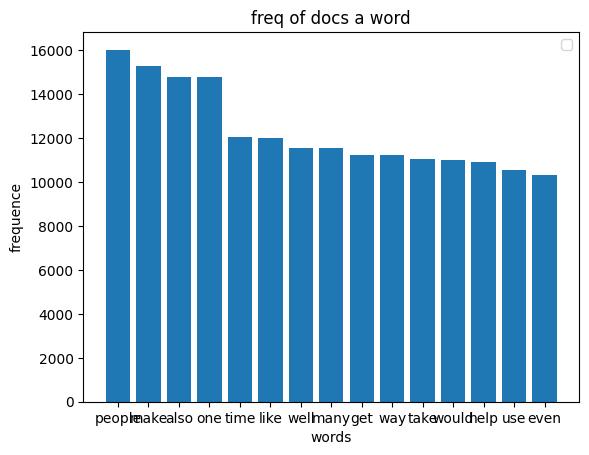

In [19]:
word_docs=tokenizer_train.word_docs
word_docs_Desc=sorted(word_docs.items(), key=lambda x:x[1],reverse=True)
word_docs_Desc_dict=dict(word_docs_Desc)

plt.bar(list(word_docs_Desc_dict.keys())[:15],list(word_docs_Desc_dict.values())[:15])
plt.xlabel("words")#横坐标名字
plt.ylabel("frequence")#纵坐标名字
plt.title('freq of docs a word')
plt.legend(loc = "best")#图例
plt.savefig('word_docs.jpg')
plt.show

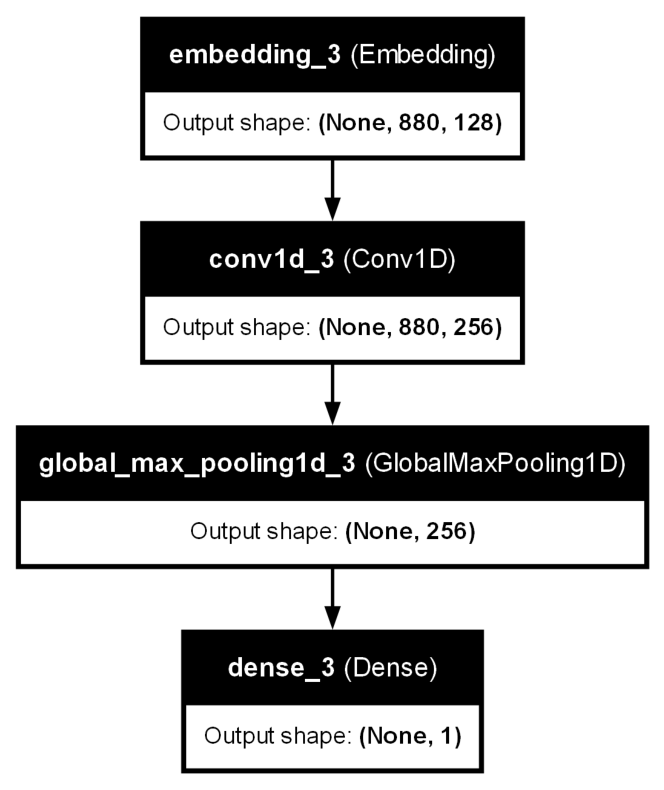

In [20]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB') # TB:top-bottom
plt.figure(figsize=(10,10))
img = plt.imread('model.png')
plt.imshow(img)
plt.axis('off')
plt.savefig('CNN.jpg')
plt.show()